In [1]:
import re

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import re
import pandas as pd

def parse_data(data_strings):
    parsed_data = []
    
    for entry in data_strings:
        match = re.search(r"bayesian_search_dann_v3_\w+ \| lambda_rgl=([-\d\.]+), Architecture=([-\d\.]+), LAMBDA_DANN=([-\d\.]+) --> Accuracy: ([-\d\.]+)", entry)
        if match:
            parsed_data.append({
                "Run_ID": re.search(r"bayesian_search_dann_v3_(\w+)", entry).group(1),
                "lambda_rgl": float(match.group(1)),
                "Architecture": float(match.group(2)),
                "LAMBDA_DANN": float(match.group(3)),
                "Accuracy": float(match.group(4))
            })
    
    return pd.DataFrame(parsed_data)

# Read data from file
def read_file(file_path):
    with open(file_path, 'r') as file:
        data_strings = file.readlines()
    return [line.strip() for line in data_strings if line.strip()]

# Sample usage
data_strings = read_file("exps/bayesian_search_dann_v3/bayesian_search_dann_v3.txt")

# Parse and create DataFrame
df = parse_data(data_strings)

In [7]:
df['sum_lambdas'] = df['lambda_rgl'] + df['LAMBDA_DANN']
df[(df.Accuracy > .38)].sort_values(by="sum_lambdas", ascending=False).head(10)

,Run_ID,lambda_rgl,Architecture,LAMBDA_DANN,Accuracy,sum_lambdas
10,291cb8a8,-0.518978,0.0,1.298674,0.393755,0.779696
6,cfe2ce5a,1.342235,0.0,-0.816660,0.411431,0.525575
4,8c490f2e,-3.818100,0.0,3.989312,0.398322,0.171211
109,6e0745ff,5.405165,0.0,-5.308576,0.400598,0.096589
15,49995910,-5.953323,0.0,5.997188,0.412858,0.043865
13,fd6802f8,6.000000,0.0,-6.000000,0.405236,0.000000
98,f174f5a2,1.401061,0.0,-1.556518,0.418001,-0.155457
90,28c76f5d,3.584171,0.0,-3.834158,0.399523,-0.249987
87,d601638e,-3.357413,0.0,3.068380,0.409864,-0.289033
104,3c2d8991,-0.717994,0.0,0.352223,0.402990,-0.365770


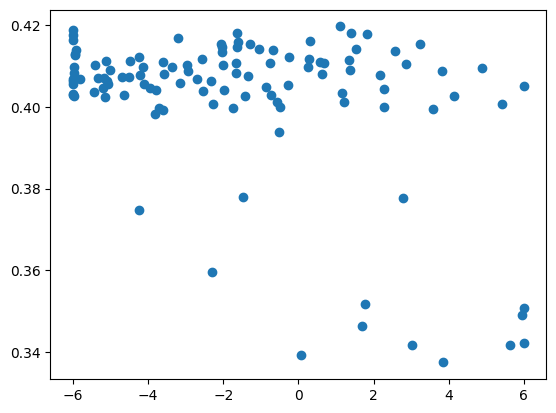

In [20]:
plt.plot(df.lambda_rgl, df.Accuracy, 'o')

Looking into run number b3d029a6 as its accuracy is mediocre and mbda rgl is 1e5

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


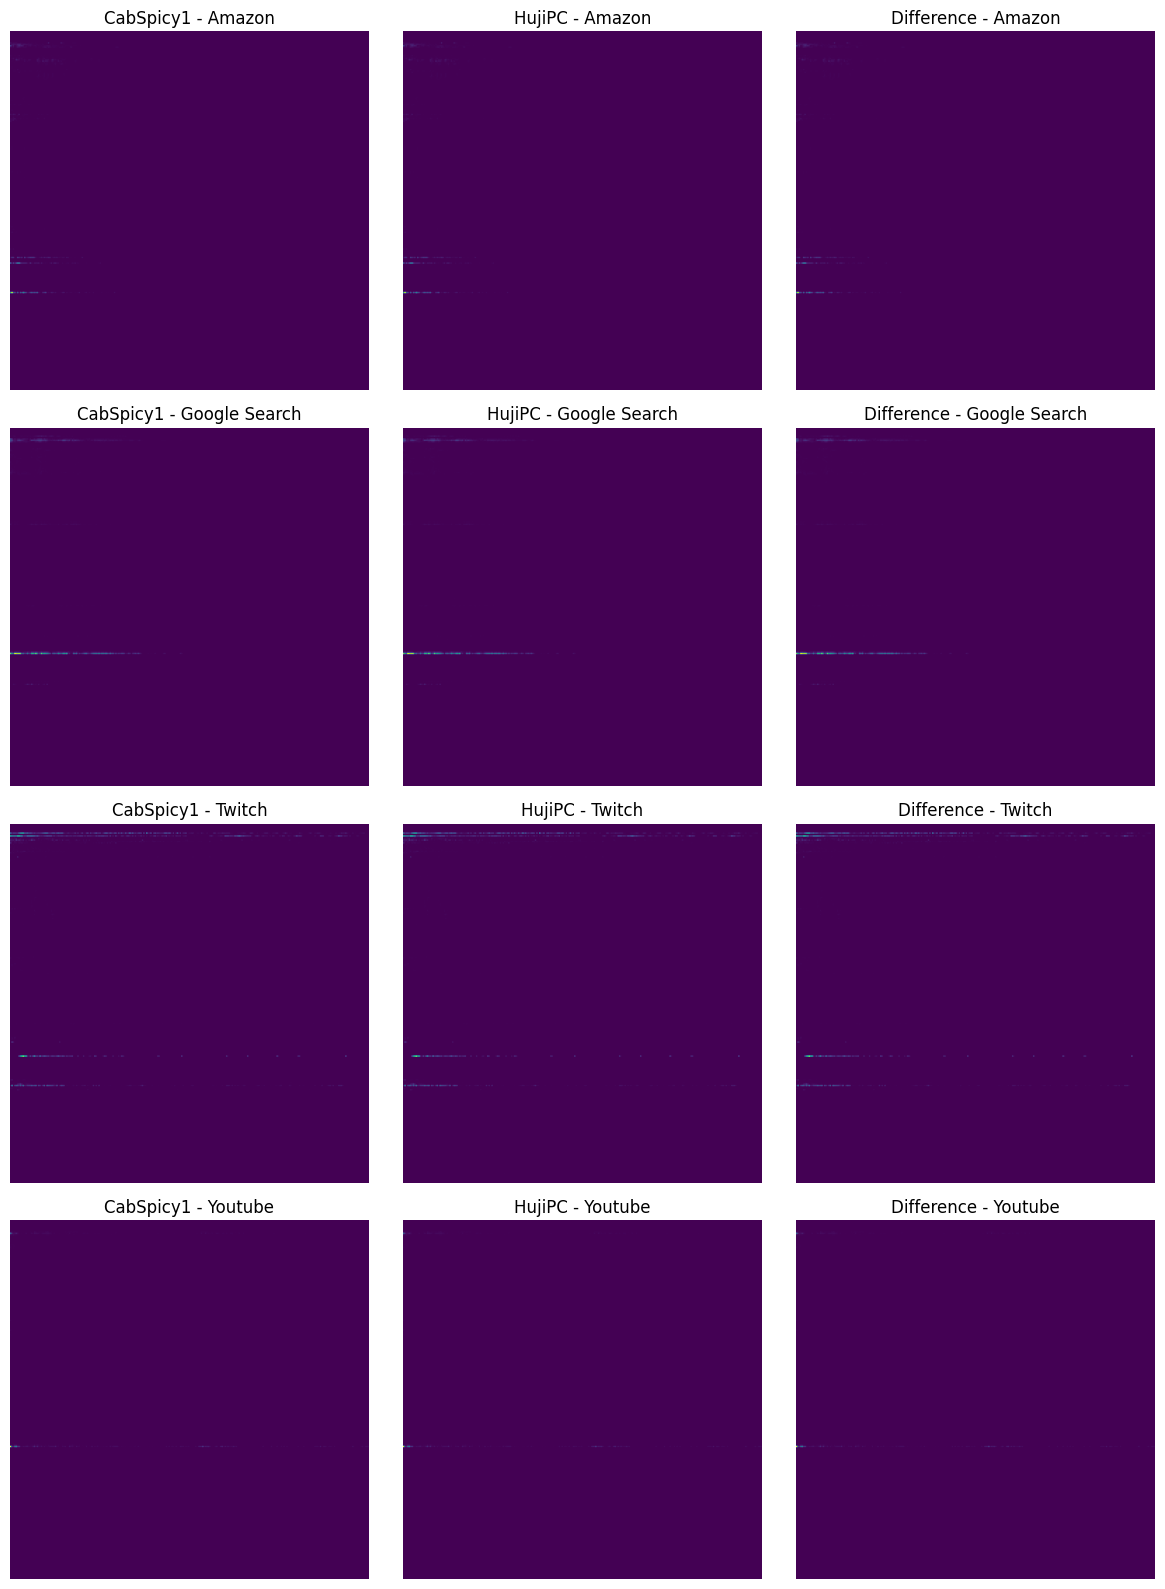

In [30]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm
from config import Config

cfg = Config()

# Function to load cached dataset
def load_cached_dataset(location, data_path, batch_size):
    dataset_path = data_path / f"cached_datasets/datasets_{location}_256.pkl"
    with open(dataset_path, "rb") as f:
        train_dataset, _ = pickle.load(f)
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Configurations
DATA_PATH = cfg.DATA_PATH
# LOCATIONS = cfg.LOCATIONS[:2]  # Ensuring exactly two locations
LOCATIONS = ['CabSpicy1', 'HujiPC'] 
BATCH_SIZE = 100
NUM_CLASSES = 4
SAMPLES_PER_CLASS = 200
LABEL_INVERSE_MAPPING = {v: k for k, v in cfg.LABEL_MAPPING.items()}

mean_images = {loc: [] for loc in LOCATIONS}

# Process each location simultaneously collecting all classes
for loc in tqdm(LOCATIONS):
    loader = load_cached_dataset(loc, DATA_PATH, batch_size=BATCH_SIZE)
    class_images_collected = {class_label: [] for class_label in range(NUM_CLASSES)}

    for images, labels in loader:
        for class_label in range(NUM_CLASSES):
            class_images = images[labels == class_label]
            class_images_collected[class_label].extend(class_images)

        if all(len(class_images_collected[cls]) >= SAMPLES_PER_CLASS for cls in range(NUM_CLASSES)):
            break

    for class_label in range(NUM_CLASSES):
        collected = class_images_collected[class_label][:SAMPLES_PER_CLASS]
        if len(collected) < SAMPLES_PER_CLASS:
            print(f"Warning: Only {len(collected)} images collected for class {class_label} at {loc}")
        collected = torch.stack(collected)
        mean_image = collected.mean(dim=0).cpu().numpy()
        mean_images[loc].append(mean_image)

# Plotting
fig, axes = plt.subplots(NUM_CLASSES, 3, figsize=(12, 16))

for class_label in range(NUM_CLASSES):
    img_loc1 = mean_images[LOCATIONS[0]][class_label]
    img_loc2 = mean_images[LOCATIONS[1]][class_label]
    img_diff = np.abs(img_loc1 - img_loc2)

    axes[class_label, 0].imshow(img_diff)
    axes[class_label, 0].set_title(f"{LOCATIONS[0]} - {LABEL_INVERSE_MAPPING[class_label]}")
    axes[class_label, 0].axis('off')

    axes[class_label, 1].imshow(img_diff)
    axes[class_label, 1].set_title(f"{LOCATIONS[1]} - {LABEL_INVERSE_MAPPING[class_label]}")
    axes[class_label, 1].axis('off')

    axes[class_label, 2].imshow(img_diff)
    axes[class_label, 2].set_title(f"Difference - {LABEL_INVERSE_MAPPING[class_label]}")
    axes[class_label, 2].axis('off')

# plt.title("Comparison of Mean Images Across Locations and Classes")
plt.tight_layout()
plt.show()

In [28]:
LOCATIONS: list = [
        'AwsCont', 'BenContainer', 'CabSpicy1',
        'HujiPC', 'TLVunContainer1', 'TLVunContainer2'
    ]

for loc in tqdm(LOCATIONS):
    loader = load_cached_dataset(loc, DATA_PATH, batch_size=BATCH_SIZE)

    n = 0
    for images, labels in loader:
        n+= 1
    print(f"Collected {n} images for location {loc}")


 17%|█▋        | 1/6 [00:02<00:11,  2.37s/it]

Collected 140 images for location AwsCont


 33%|███▎      | 2/6 [00:02<00:05,  1.26s/it]

Collected 31 images for location BenContainer


 50%|█████     | 3/6 [00:12<00:15,  5.18s/it]

Collected 160 images for location CabSpicy1


 67%|██████▋   | 4/6 [00:55<00:40, 20.11s/it]

Collected 230 images for location HujiPC


 83%|████████▎ | 5/6 [01:19<00:21, 21.55s/it]

Collected 133 images for location TLVunContainer1


100%|██████████| 6/6 [01:42<00:00, 17.03s/it]

Collected 126 images for location TLVunContainer2
